# Prepare data

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
from pytz import timezone  # For timezone handling

# from sklearn.model_selection import train_test_split
# Load data from CSV file into a DataFrame
file_name = "announcements.csv"
df = pd.read_csv(file_name, parse_dates=["sort_date"])
df["sort_date"] = df["sort_date"].dt.tz_localize(timezone("Asia/Kolkata"))  # Set IST timezone
# df = pd.read_csv(file_name, parse_dates=True)

# Convert 'sort_date' column to datetime
# df["sort_date"] = pd.to_datetime(df["sort_date"])

# Group by date and count number of entries
# grouped_data = df.groupby(df["sort_date"].dt.date).size().reset_index(name="count")

df_shuffled = df.sample(frac=1, random_state=42)  # random_state for reproducibility

# Calculate the number of rows for each set (e.g., 70% for training and 30% for testing)
train_size = int(0.5 * len(df_shuffled))

# Divide the shuffled DataFrame into two sets
df_train = df_shuffled.iloc[:train_size]
df_train = df_train.sort_values(by="sort_date")

grouped_data = df_train.groupby(df["desc"]).size().reset_index(name="count")

# Plot data
# plt.figure(figsize=(10, 6))
# plt.bar(grouped_data["desc"], grouped_data["count"], color="skyblue")
# plt.title("Number of Entries by Date")
# plt.xlabel("desc")
# plt.ylabel("Number of Entries")
# plt.xticks(rotation=45)
# # plt.tight_layout()
# plt.show()

# Next action items?
Check the counts.

In [5]:
display(grouped_data)

,desc,count
0,AGM/Book Closure,3
1,Acquisition,480
2,Acquisition-XBRL,91
3,Addendum,6
4,Address Change,7
5,"Agreements,Contracts,Arrangements,MOU-XBRL",18
6,Agreements/Contracts/Arrangements/ MOU's PARA A,5
7,Agreements/Contracts/Arrangements/ MOU's PARA B,6
8,Allotment of ESOP/ESPS,118
9,Allotment of Securities,520


In [44]:
# pd.set_option("display.max_rows", 3000)
frs = df[df["desc"] == "Financial Result Updates"]
frs.set_index("sort_date", inplace=True)
# frs[["symbol", "an_dt", "attchmntFile"]]

# from historical_data import DataUtil
# file_path = DataUtil.get_intraday_csv_path(frs.iloc[0].symbol, frs.iloc[0].sort_date)
# df = pd.read_csv(file_path, index_col="date", parse_dates=True)
# df.head()

# Check the impact of these reports on stock market by their type?
What's the benefit of this?

I'll know which desc types are affecting the market and which don't.

I'll filter out those desc which are not affecting and focus only on those affecting.

Let's focus only on financial reports. We'll visit rest later by each category.

# What's the goal?
[ ] - Find patterns in a data which can lead to some prediction to either go long or short at the timing of the report.

Underlying assumption is that whenever there is a new financial report published in NSE website, there's a huge impact on the price of the underlying stock. Can I ride that impact in my favor? 
If I can come up with ways to decide to either go long or short after the report is published, I can make very good profit.

Let's find, how much the market changes after these reports are published.
- Find high - low, from the minute right before the candle is published, and after the candle is published

In [72]:
import numpy as np
from historical_data import DataUtil
import datetime as dt

market_open_time = dt.time(9, 15)
market_end_time = dt.time(15, 30)

def get_file_path_from_df(row):
    df = pd.DataFrame([])
    cur_date = row.name
    cur_time = cur_date.time()
    market_open_time = dt.time(9, 15)
    market_end_time = dt.time(15, 30)
    if not (market_open_time <= cur_time <= market_end_time):
        cur_date += dt.timedelta(days=1)
    try:
        while df.shape[0] == 0:
            file_path = DataUtil.get_intraday_csv_path(row.symbol, cur_date)
            try:
                df = pd.read_csv(file_path, index_col="date", parse_dates=True)
            except pd.errors.EmptyDataError:
                df = pd.DataFrame([])
            cur_date += dt.timedelta(days=1)
    except Exception as e:
        print(f"symbol: {row.symbol}, date: {cur_date} {e}, {type(e)}")
    return df

frs["ic"] = frs.apply(get_file_path_from_df, axis=1) # Intraday candles

/tmp/ipykernel_4735/2350515429.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frs["ic"] = frs.apply(get_file_path_from_df, axis=1) # Intraday candles


# Is my assumption correct that after a report is published, there's significant change in the volatility of the stock market.
- If dataframe sort_date is not in market hours, check all the candle's high and low.
- If sort_date is in market hours, only check high low of candle's starting on and after sort_date

In [75]:
def get_after_report_change(row):
    if market_open_time <= row.name.time() <= market_end_time:
        # print(f"symbol: {row.symbol}, date:{row.sort_date} {row.ic.columns}")
        after_candles = row.ic[row.ic.index >= row.name.replace(second=0)]
    else:
        after_candles = row.ic
    return abs(after_candles.high.max() - after_candles.low.min()) / after_candles.iloc[0].open
frs["after_report_change_pc"] = frs.apply(get_after_report_change, axis=1)
frs["after_report_change_pc"] = frs["after_report_change_pc"] * 100
frs[["symbol", "after_report_change_pc"]].head()
# frs[["symbol", "sort_date", "after_report_change_pc"]].head()

/tmp/ipykernel_4735/3114930641.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frs["after_report_change_pc"] = frs.apply(get_after_report_change, axis=1)


In [84]:
frs["after_report_change_pc"].mean()

4.867608940846302

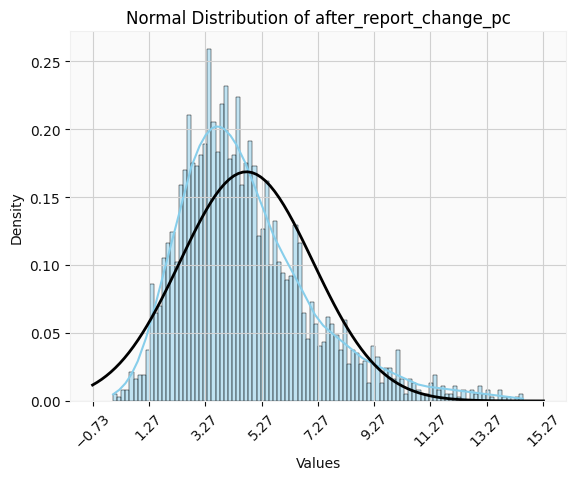

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm  # Import the normal distribution from SciPy

# Assuming df is your DataFrame and 'column_name' is the column you want to plot
pc_change = frs[frs['after_report_change_pc'] < 15]['after_report_change_pc']

# Plot the histogram of the data
sns.histplot(pc_change, kde=True, stat='density', color='skyblue', bins=100)

# Fit a normal distribution to the data
mu, sigma = norm.fit(pc_change)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, sigma)
plt.plot(x, p, 'k', linewidth=2)
plt.xticks(np.arange(xmin, xmax, 2), rotation=45)  # Adjust the step size as needed

# Add labels and title
plt.xlabel('Values')
plt.ylabel('Density')
plt.title('Normal Distribution of {}'.format('after_report_change_pc'))

# Show the plot
plt.show()

# Get all the reports which have been released during market hours
# Check the market movement before the release of the report and save it in a column
# Set the immediate movement before reversal?

In [113]:
import mplfinance as mpf

in_market = frs.between_time(market_open_time, market_end_time)
# for index, st in in_market.head(10).iterrows():
#     mpf.plot(st["ic"], type='candle', volume=True, style='yahoo', title=f'{st.symbol}-{st.name}', figsize=(20, 12))

import matplotlib.pyplot as plt
from mplfinance import candlestick_ohlc

for index, st in in_market.head(10).iterrows():
    # # Set the x-axis limits
    xlim = (st["ic"].index[0], st["ic"].index[-1])
    # # Create a new figure and set the size
    fig, ax = plt.subplots(figsize=(10, 5))
    
    # # Plot the OHLC data
    # ax.plot(st["ic"].index, st["ic"]['open'], label='Open')
    # ax.plot(st["ic"].index, st["ic"]['high'], label='High')
    # ax.plot(st["ic"].index, st["ic"]['low'], label='Low')
    # ax.plot(st["ic"].index, st["ic"]['close'], label='Close')
    
    # # Set the x-axis limits and labels
    # ax.set_xlim(xlim)
    # ax.set_xlabel('Date')
    
    # # Set the y-axis label
    # ax.set_ylabel('Price')
    
    # # Add a legend
    # ax.legend()
    
    # # Show the plot
    # plt.show()

    # Set the x-axis limits
    # xlim = (data.index[0], data.index[-1])
    
    # Create a new figure and set the size
    # fig, ax = plt.subplots(figsize=(10, 5))
    
    # Convert the date to the mdates format
    st["ic"]['Date'] = data.index.map(mdates.date2num)
    
    # Plot the candlestick chart
    candlestick_ohlc(ax, st["ic"].values, width=0.6, colorup='green', colordown='red')
    
    # Set the x-axis limits and labels
    ax.set_xlim(xlim)
    ax.set_xlabel('Date')
    
    # Set the y-axis label
    ax.set_ylabel('Price')
    
    # Show the plot
    plt.show()

ImportError: cannot import name 'candlestick_ohlc' from 'mplfinance' (/home/nitin/anaconda3/envs/nse/lib/python3.12/site-packages/mplfinance/__init__.py)

In [194]:
import yaml

from bokeh.layouts import column
from bokeh.models import ColumnDataSource, Slider
from bokeh.plotting import figure
from bokeh.themes import Theme
from bokeh.io import show, output_notebook

from bokeh.models import ColumnDataSource, Span, NumeralTickFormatter, HoverTool, Span, CustomJS

output_notebook()

from bokeh.models import BoxAnnotation
from bokeh.plotting import figure, show
from bokeh.models import CrosshairTool

# df = pd.DataFrame(MSFT)[60:120]
# df["date"] = pd.to_datetime(df["date"])

# non_working_days = df[['date']].assign(diff=df['date'].diff()-pd.Timedelta('1D'))
# non_working_days = non_working_days[non_working_days['diff']>=pd.Timedelta('1D')]

# df['date'] += pd.Timedelta('12H') # move candles to the center of the day

TOOLS = "pan,crosshair,wheel_zoom,hover,box_zoom,reset,save"

for index, st in in_market.head(10).iterrows():
    st["ic"]["color"] = np.where(st["ic"]["close"] > st["ic"]["open"], "green", "red")
    source = ColumnDataSource(st["ic"])
    p = figure(
            x_axis_type="datetime",
            title=f"{st.symbol} - Report: {st.name}",
            min_width=2000,
            min_height=800,
            background_fill_color="#222222"
        )
    crosshair_tool = CrosshairTool(
        dimensions="both",
        line_color="red",
        line_alpha=0.8,
    )
    p.add_tools(crosshair_tool)
    hover = HoverTool(
        tooltips=[("Date", "@date"), ("Open", "@open"), ("High", "@high"), ("Low", "@low"), ("Close", "@close")]
    )
    p.add_tools(hover)
    p.segment(st["ic"].index, st["ic"].high, st["ic"].index, st["ic"].low, color="white")
    p.vbar(st["ic"].index[dec], pd.Timedelta('1m'), st["ic"]["open"][dec.values], st["ic"]["close"][dec.values], fill_color="red", line_color="white", line_width=.1)
    p.vbar(st["ic"].index[inc], pd.Timedelta('1m'), st["ic"]["open"][inc.values], st["ic"]["close"][inc.values], fill_color="green", line_color="white", line_width=.1)
    show(p)

Loading BokehJS ...